<a href="http://landlab.github.io"><img style="float: left; height: 175px; width: 175px" src="../landlab_logo_picture.jpg"></a> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# The transport-length hillslope diffuser

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/release/README.md">https://github.com/landlab/tutorials/blob/release/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

# WARNING
**Some components used in this tutorial are not included in the latest release of Landlab. You need to do the [developer install](https://github.com/landlab/landlab/wiki/Installing-Landlab-from-source-code-(%22developer-install%22) to use them and run this tutorial.**

This ipython notebook illustrtes running the transport-length-model hillslope diffusion component in a simple example.

# The basics:

This component uses an approach similar to Davy and Lague (2009)'s equation for fluvial erosion and transport, and applies it to hillslope diffusion.
Formulation and implementation were inspired by Carretier et al (2016), see this paper and references therein for justification.

## Theory

The elevation z of a point of the landscape (grid node) changes according to:

\begin{equation}
 \frac{\partial z}{\partial t} = -\epsilon + D + U  \tag{1}\label{eq:1}
\end{equation}


and we define:
\begin{equation}
 D = \frac{q_s}{L}  \tag{2}\label{eq:2}
\end{equation}



where $\epsilon$ is the local erosion rate [*L/T*], *D* the local deposition rate [*L/T*], *U* the uplift (or subsidence) rate [*L/T*], $q_s$ the incoming sediment flux per unit width [*L$^2$/T*] and *L* is the **transport length**.

We specify the erosion rate $\epsilon$ and the transport length *L*:

\begin{equation}
 \epsilon = \kappa S  \tag{3}\label{eq:3}
\end{equation}



\begin{equation}
 L = \frac{dx}{1-({S}/{S_c})^2}  \tag{4}\label{eq:4}
\end{equation}

where $\kappa$ [*L/T*] is an erodibility coefficient, $S$ is the local slope [*L/L*] and $S_c$ is the critical slope [*L/L*]. 

Thus, the elevation variation results from the difference between local rates of detachment and deposition. 

The detachment rate is proportional to the local gradient. However, the deposition rate (*$q_s$/L*) depends on the local slope and the critical slope:
- when $S \ll S_c$, most of the sediment entering a node is deposited there, this is the pure diffusion case. In this case, the sediment flux $q_s$ does not include sediment eroded from above and is thus "local".
- when $S \approx S_c$, *L* becomes infinity and there is no redeposition on the node, the sediments are transferred further downstream.  This behaviour corresponds to mass wasting, grains can travel a long distance before being deposited. In that case, the flux $q_s$ is "non-local" as it incorporates sediments that have both been detached  locally and transited from upslope.
- for an intermediate $S$, there is a prgogressive transition between pure creep and "balistic" transport of the material. This is consistent with experiments (Roering et al., 2001; Gabet and Mendoza, 2012).



## Contrast with the non-linear diffusion model

Previous models typically use a "non-linear" diffusion model proposed by different authors (e.g. Andrews and Hanks, 1985; Hanks, 1999; Roering et al., 1999) and supported by $^{10}$Be-derived erosion rates (e.g. Binnie et al., 2007) or experiments (Roering et al., 2001). It is usually presented in the followin form:

$ $

\begin{equation} 
 \frac{\partial z}{\partial t} = \frac{\partial q_s}{\partial x}  \tag{5}\label{eq:5}
\end{equation}

$ $
\begin{equation}
 q_s = \frac{\kappa' S}{1-({S}/{S_c})^2}   \tag{6}\label{eq:6}
\end{equation}

where $\kappa'$ [*L$^2$/T*] is a diffusion coefficient.

This description is thus based on the definition of a flux of transported sediment parallel to the slope:
- when the slope is small, this flux refers to diffusion processes such as aoil creep, rain splash or diffuse runoff
- when the slope gets closer to critical slope, the flux increases dramatically, simulating on average the cumulative effect of mass wasting events.


Despite these conceptual differences, Eq ($\ref{eq:3}$) and ($\ref{eq:4}$) predict similar topographic evolution to the 'non-linear' diffusion equations for $\kappa' = \kappa dx$, as shown in the following example.

# Example 1:



First, we import what we'll need:

In [1]:
import numpy as np
from landlab import RasterModelGrid
from landlab.components import FlowDirectorSteepest, TransportLengthHillslopeDiffuser

from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title
from landlab.plot import imshow_grid

#to plot figures in the notebook:
%matplotlib inline

Make a grid and set boundary conditions:

In [2]:
mg = RasterModelGrid((100, 100), 10.)  # raster grid with 100 rows, 100 columns and dx=10m
z = np.random.rand(10000)  # random noise for initial topography
_ = mg.add_field('node', 'topographic__elevation', z)

mg.set_closed_boundaries_at_grid_edges(False, True, False, True) # N and S boundaries are closed, E and W are open 

Set the initial and run conditions:

In [3]:
total_t = 2000000.  # total run time (yr)
dt = 1000.   # time step (yr)
nt = int(total_t // dt)  # number of time steps
uplift_rate = 0.0001   # uplift rate (m/yr)

kappa = 0.001  # erodibility (m/yr)
Sc = 0.6   # critical slope

Instantiate the components:
The hillslope diffusion component must be used together with a flow router/director that provides the steepest downstream slope for each node, with a D4 method (creates the field *topographic__steepest_slope* at nodes).

In [4]:
fdir = FlowDirectorSteepest(mg)
tl_diff = TransportLengthHillslopeDiffuser(mg, erodibility=kappa, slope_crit=Sc)

Run the components for 2 Myr and trace an East-West cross-section of the topography every 100 kyr:

0.0
100000.0
200000.0
300000.0
400000.0
500000.0
600000.0
700000.0
800000.0
900000.0
1000000.0
1100000.0
1200000.0
1300000.0
1400000.0
1500000.0
1600000.0
1700000.0
1800000.0
1900000.0


Text(0,0.5,'z (m)')

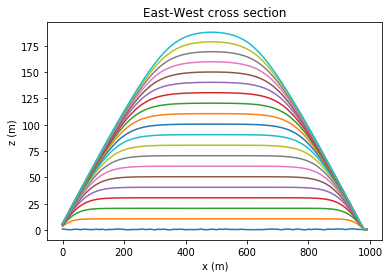

In [5]:
for t in range(nt):
    fdir.run_one_step()
    tl_diff.run_one_step(dt)
    z[mg.core_nodes] += uplift_rate * dt  # add the uplift

    # add some output to let us see we aren't hanging:
    if t % 100 == 0:
        print(t*dt)
        
        # plot east-west cross-section of topography:
        x_plot = range(0, 1000, 10)
        z_plot = z[101:201]
        figure('cross-section')
        plot(x_plot, z_plot)
        

figure('cross-section')
title('East-West cross section')
xlabel('x (m)')
ylabel('z (m)')

And plot final topography:

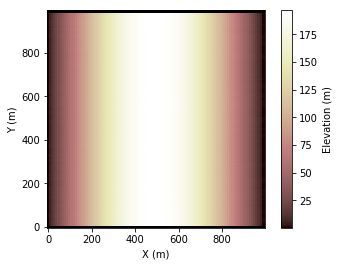

In [6]:
figure('final topography')
im = imshow_grid(mg, 'topographic__elevation', grid_units = ['m','m'], var_name='Elevation (m)')

This behaviour corresponds to the evolution observed using a classical non-linear diffusion model.

# Example 2: 

In this example, we show that when the slope is steep ($S \geq S_c$), the transport-length hillsope diffusion simulates mass wasting, with long transport distances.

First, we create a grid: the western half of the grid is flat at 0m of elevation, the eastern half is a 45-degree slope.


Text(0,0.5,'z (m)')

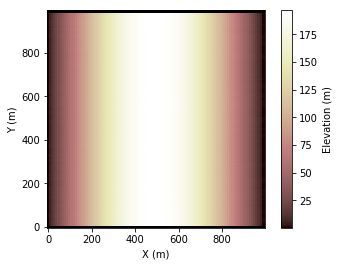

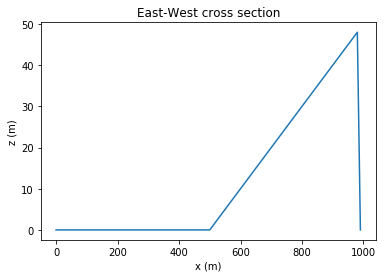

In [7]:
# Create grid and topographic elevation field:
mg2 = RasterModelGrid((100, 100), 10.)

z = np.zeros(mg2.number_of_nodes)
z[mg2.node_x > 500] = mg2.node_x[mg2.node_x < 490] / 10
_ = mg2.add_field('node', 'topographic__elevation', z)

# Set boundary conditions:
mg2.set_closed_boundaries_at_grid_edges(False, True, False, True)

# Show initial topography:
im = imshow_grid(mg, 'topographic__elevation', grid_units = ['m','m'], var_name='Elevation (m)')

# Plot an east-west cross-section of the initial topography:
z_plot = z[101:201]
x_plot = range(0, 1000, 10)
figure(2)
plot(x_plot, z_plot)
title('East-West cross section')
xlabel('x (m)')
ylabel('z (m)')

Set the run conditions:

In [8]:
total_t = 1000000.   # total run time (yr)
dt = 1000.   # time step (yr)
nt = int(total_t // dt)   # number of time steps

Instantiate the components:

In [9]:
fdir = FlowDirectorSteepest(mg2)
tl_diff = TransportLengthHillslopeDiffuser(mg2, erodibility=0.001, slope_crit=0.6)

Run for 1 Myr, plotting the cross-section regularly:

0.0
100000.0
200000.0
300000.0
400000.0
500000.0
600000.0
700000.0
800000.0
900000.0


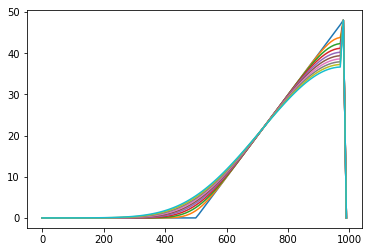

In [10]:
for t in range(nt):
    fdir.run_one_step()
    tl_diff.run_one_step(dt)

    # add some output to let us see we aren't hanging:
    if t % 100 == 0:
        print(t*dt)
        z_plot = z[101:201]
        figure(2)
        plot(x_plot, z_plot)

The material is diffused from the top and along the slope and it accumulates at the bottom, where the topography flattens.

As a comparison, the following code uses linear diffusion on the same slope:

0.0
100000.0
200000.0
300000.0
400000.0
500000.0
600000.0
700000.0
800000.0
900000.0


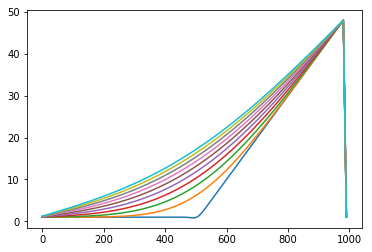

In [11]:
# Import Linear diffuser:
from landlab.components import LinearDiffuser

# Create grid and topographic elevation field: 
mg3 = RasterModelGrid((100, 100), 10.)
z = np.ones(mg.number_of_nodes)
z[mg.node_x > 500] = mg.node_x[mg.node_x < 490] / 10
_ = mg3.add_field('node', 'topographic__elevation', z)

# Set boundary conditions:
mg3.set_closed_boundaries_at_grid_edges(False, True, False, True)

# Instantiate components:
fdir = FlowDirectorSteepest(mg3)
diff = LinearDiffuser(mg3, linear_diffusivity=0.1)

# Set run conditions:
total_t = 1000000.
dt = 1000.
nt = int(total_t // dt)

# Run for 1 Myr, plotting east-west cross-section regularly:
for t in range(nt):
    fdir.run_one_step()
    diff.run_one_step(dt)

    # add some output to let us see we aren't hanging:
    if t % 100 == 0:
        print(t*dt)
        z_plot = z[101:201]
        figure(2)
        plot(x_plot, z_plot)